In [45]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import contextily as ctx
import numpy as np
import geopandas as gpd
from pyproj import Transformer
from scipy.interpolate import interp1d
from IPython.display import Image, HTML

In [2]:
def rgb2grey(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    grey = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return grey * 0.5

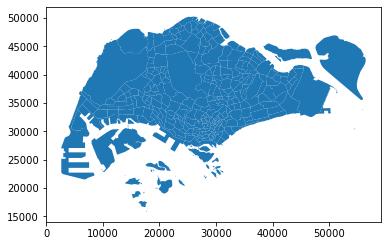

In [4]:
# Load in subzones
sz = gpd.read_file('subzones_ura/MP14_SUBZONE_NO_SEA_PL.shp') #.to_crs('EPSG:4326')
sz.plot()

In [5]:
sz.total_bounds

array([ 2667.538 , 15748.721 , 56396.44  , 50256.3343])

In [28]:
sz.to_crs('EPSG:4326').total_bounds

array([103.60570071,   1.1586987 , 104.08848307,   1.47077483])

In [6]:
w, s, e, n = sz.to_crs('EPSG:4326').total_bounds

In [7]:
_ = ctx.howmany(w, s, e, n, 13, ll=True)

Using zoom level 13, this will download 96 tiles


In [8]:
%%time
#img, ext = ctx.bounds2img(w, s, e, n, 12, url='http://maps-b.onemap.sg/v2/Original/{z}/{x}/{y}.png', ll=True)
img, ext = ctx.bounds2img(w, s, e, n, 13, url=getattr(ctx.sources, 'ST_TERRAIN'), ll=True)

CPU times: user 747 ms, sys: 321 ms, total: 1.07 s
Wall time: 4.34 s


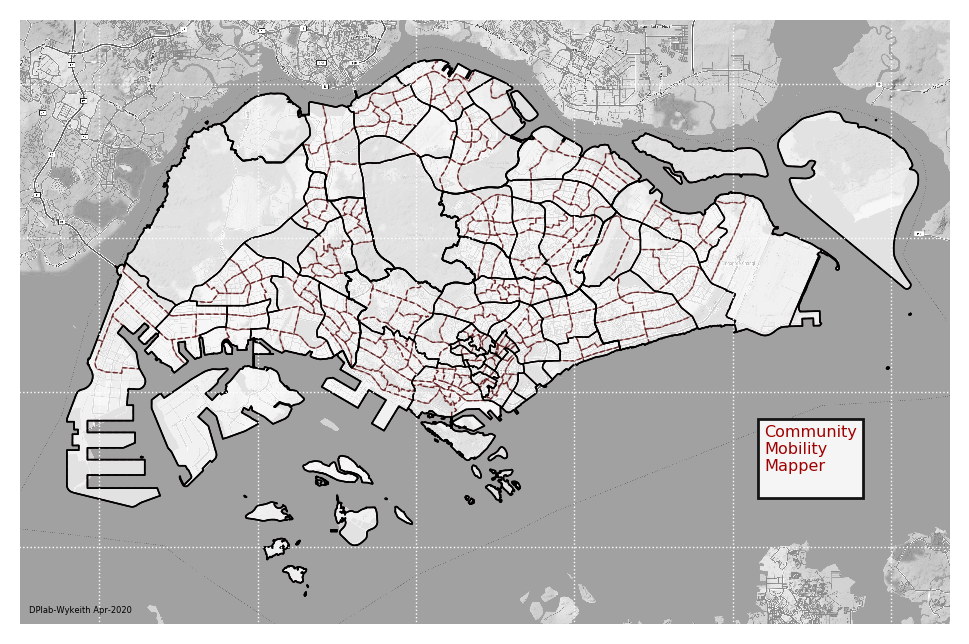

In [53]:
#plt.xkcd()
plt.figure(dpi=200)
ax = plt.axes(frameon=False)
#plt.grid(color='white', linestyle='dotted', linewidth=0.5)
data = rgb2grey(img)
ax.imshow(data, extent=ext, cmap=plt.get_cmap('gray'))
sz.to_crs('EPSG:3857').plot(ax=ax,facecolor='white',alpha=.7, linestyles='dashed', edgecolor='#4F0000',lw=0.5)
sz.to_crs('EPSG:3857').dissolve(by='REGION_C').plot(ax=ax,facecolor='none', edgecolor='k',lw=0.6)
sz.to_crs('EPSG:3857').dissolve(by='PLN_AREA_C').plot(ax=ax,facecolor='none', edgecolor='k',lw=0.5)
plt.axis('tight')
xstart, xend = ax.get_xlim()
ystart, yend = ax.get_ylim()
plt.vlines(np.arange(xstart-5000, xend, 10000),0,166000, colors='white', linestyles='dotted', linewidths=0.5)
plt.hlines(np.arange(ystart-5000, yend, 10000),0,11589000, colors='white', linestyles='dotted', linewidths=0.5)
plt.xticks([])
plt.yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
extents = ax.axis()

ax.text(x=0.8,
         y=0.33,
         s="Community\nMobility\nMapper\n",
         horizontalalignment="left",
         verticalalignment="top",
         transform=ax.transAxes,
         fontsize='xx-small',
         color='#9F0000',
         bbox={'alpha':0.9,
               'facecolor':'white',
               'edgecolor':'k',
               'lw': 1,
               'pad': 2})

ax.text(x=0.01,
         y=0.03,
         s="DPlab-Wykeith Apr-2020",
         horizontalalignment="left",
         verticalalignment="top",
         transform=ax.transAxes,
         fontsize=3)

plt.savefig('map.png', bbox_inches='tight', pad_inches=0, transparency=True)
plt.show()
plt.close()

In [36]:
# From Web Mercator to SVY21
transformer = Transformer.from_crs("EPSG:3857", "EPSG:3414", always_xy=True)

# Read in map
map = plt.imread('map.png')

xmin,ymin = transformer.transform(extents[0], extents[2])
xmax,ymax = transformer.transform(extents[1], extents[3])

xmap = interp1d([xmin,xmax],[0,map.shape[1]])
ymap = interp1d([ymin,ymax],[map.shape[0],0])

In [37]:
sz.loc[sz.SUBZONE_N.str.contains('CENTRAL WATER CATCHMENT')]

,OBJECTID,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area,geometry
295,296,1,CENTRAL WATER CATCHMENT,CCSZ01,N,CENTRAL WATER CATCHMENT,CC,NORTH REGION,NR,52D00685FE621970,2016-05-11,24424.4183,39849.0456,30538.246177,3.714785e+07,"POLYGON ((25073.293 43675.363, 25130.764 43520..."


In [39]:
xdata = [int(xmap(x)) for x in sz['geometry'][312].exterior.coords.xy[0]]
ydata = [int(ymap(y)) for y in sz['geometry'][312].exterior.coords.xy[1]]
#x,y = sz.to_crs('EPSG:3857')['geometry'].exterior.coords.xy
coords = np.dstack((xdata,ydata)).flatten()

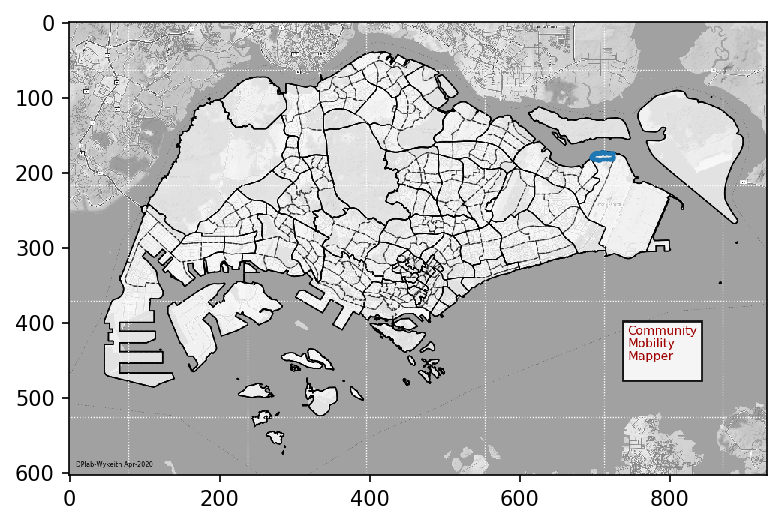

In [40]:
plt.figure(dpi=150)
plt.imshow(map)
plt.scatter(xdata,ydata,s=0.5)

In [49]:
mapstart = '''
<img src="map.png" usemap="#image-map">
<map name="image-map">
'''

## Update this when you change the basemap
mapareas = '''
\t<area target="_blank" alt="Email me" title="Email me" href="mailto:wykeith_ng@ura.gov.sg" coords="843,477,738,400" shape="rect">
'''

mapend = '''
</map>
'''

for i,row in sz.iterrows():
    try:
        xdata = [int(xmap(x)) for x in row['geometry'].exterior.coords.xy[0]]
        ydata = [int(ymap(y)) for y in row['geometry'].exterior.coords.xy[1]]
        coords = np.dstack((xdata,ydata)).flatten()
        mapareas = mapareas + '''\t<area target="_blank" title="{subzone}" href="http://www.google.com/?q={subzone}&search" coords="{coords}" shape="poly">\n'''.format(subzone=row['SUBZONE_N'],coords=','.join([str(x) for x in coords]))
    except:
        pass

In [50]:
with open('map.html','w') as f:
    f.write(mapstart + mapareas + mapend)

# Check Imagemap

In [48]:
HTML(mapstart + mapareas + mapend)

# MISC

In [24]:
sources = [i for i in dir(ctx.tile_providers) if i[0] != '_']
sources'ST_TONER_LINES'

['OSM_A',
 'OSM_B',
 'OSM_C',
 'ST_TERRAIN',
 'ST_TERRAIN_BACKGROUND',
 'ST_TERRAIN_LABELS',
 'ST_TERRAIN_LINES',
 'ST_TONER',
 'ST_TONER_BACKGROUND',
 'ST_TONER_HYBRID',
 'ST_TONER_LINES',
 'ST_TONER_LITE',
 'ST_WATERCOLOR']

In [67]:
getattr(ctx.sources, 'ST_WATERCOLOR')

'http://tile.stamen.com/watercolor/{z}/{x}/{y}.png'

In [ ]:
http://maps-b.onemap.sg/v2/Grey/{z}/{x}/{y}.png 

In [2]:
from owslib.wms import WebMapService
wms = WebMapService('http://mapservices.onemap.sg/mapproxy/service?REQUEST=GetCapabilities&SERVICE=WMTS', version='1.1.1')
wms.identification.title

'MapProxy WMS'

In [3]:
list(wms.contents)

['Default',
 'Original',
 'Grey',
 'Night',
 'singapore_3414_tms',
 'singapore_3414_wms',
 'singapore_3414_wmts',
 'singapore_landlot_wmts']

In [4]:
wms['Grey'].crsOptions

['EPSG:3414', 'EPSG:4326']

In [5]:
wms['Grey'].boundingBox

(103.359, 1.054, 104.766, 1.76, 'EPSG:4326')

In [6]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo']

In [7]:
xmin,xmax = 1000,54000
ymin,ymax = 14000,51000
ratio = (ymax-ymin)/(xmax-xmin)

img = wms.getmap(layers=['Grey'],
                 styles=[''],
                 srs='EPSG:3414',
                 bbox=[xmin,ymin,xmax,ymax],
                 size=[1000,int(1000*ratio)],
                 format='image/png',
                 transparent=True
                 )

In [8]:
with open('test.png','wb') as file:
    file.write(img.read())

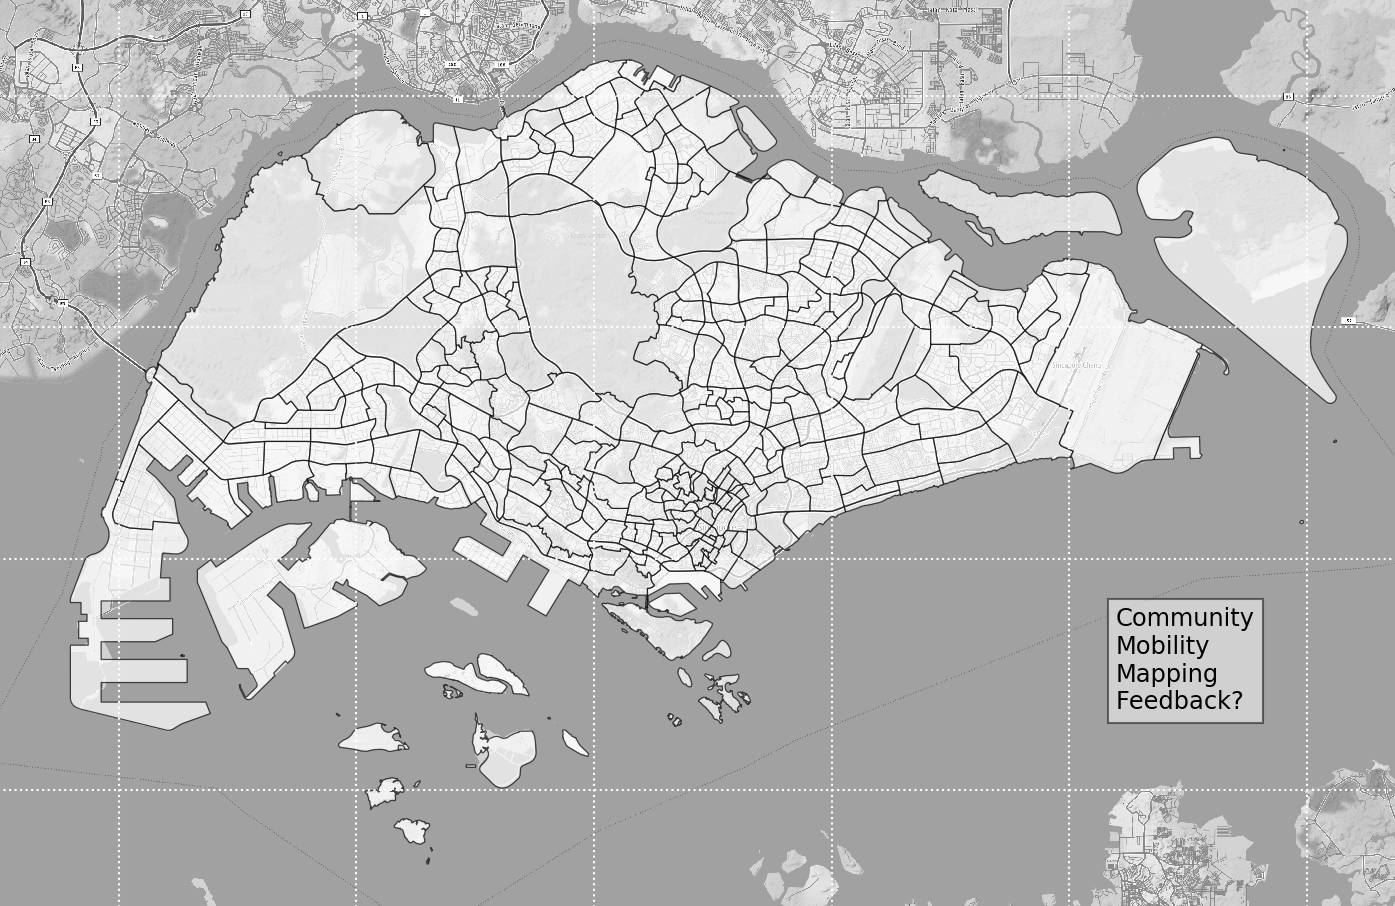

In [16]:
from IPython.display import Image, HTML
Image('map.png')

In [ ]:
plt.figure(dpi=300)
data = rgb2grey(plt.imread('test.png'))
plt.imshow(data, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)